# Anomaly Detection


*Author: Christian Camilo Urcuqui López*

*GitHub: https://github.com/urcuqui/*

```
        
        |   | /  |   |  |  |  |  |  |  /  |   |  |  |  |      [0][1][0]   
        |       /    |  |  |  |  |       /    \   \_/  /      [1][1][1]   
        |      /     |  |  |  |  |      /      \  \_/ /       [1][1][1]   
        |  |\  \     |  '--'  |  |  |\  \       \    /        Data science    
        | _| `.__\   |________|  | _| `.__\      |___|                                
```

This notebook is based on the book [1] and other tutorials in order to the explore the different techniques to reduce the dimensionality of a dataset, this is divided in the next sections:


## Packages

In [1]:
import numpy as np
import pandas as pd
import os, time
import pickle, gzip
 
""" visualization """
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

""" Data Prep and Model Evaluation"""
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

"""Algos"""
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

## Fraud Detection

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv")

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
dataX = data.copy().drop(['Class'], axis=1)
dataY = data['Class'].copy()

In [5]:
dataX.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [6]:
dataX.shape

(284807, 30)

In [7]:
dataY.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
dataX.skew()

Time      -0.035568
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
V5        -2.425901
V6         1.826581
V7         2.553907
V8        -8.521944
V9         0.554680
V10        1.187141
V11        0.356506
V12       -2.278401
V13        0.065233
V14       -1.995176
V15       -0.308423
V16       -1.100966
V17       -3.844914
V18       -0.259880
V19        0.109192
V20       -2.037155
V21        3.592991
V22       -0.213258
V23       -5.875140
V24       -0.552499
V25       -0.415793
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
dtype: float64

let's scale these things 

In [9]:
sX = pp.StandardScaler(copy=True)
featuresToScale = dataX.columns
dataX.loc[:, featuresToScale] = sX.fit_transform(dataX[featuresToScale])

hold-out

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=2018, stratify=dataY)

### Define Anomaly Score Function

Let's recall that the idea behind dimensionality reduction technique is to reduce the dimensionality of data while attempting to minize the reconstruction error.

Since fraud is rare and presumably different than normal transactions, the fraudulent transactions should exhibit the largest reconstruction error. The reconstruction error for each transaction is the sum of the squared differences between the original feature matrix and the reconstructed matrix using the dimensionality reduction algorithm. We will scale the sum of the squared differences by the max-min range of the sum of the squared differences for the entire dataset, so that all the reconstruction errors are within a zero to one range.

The transactions that have the largest sum of squared differences will have an **error close to one**, while those that have the smallest sum of squared differences will have an error close to zero.

*Zero is normal and one is anomalous (and most likely to be fraudulent).*

In [11]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

### Define Evaluation Metrics

In [12]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

In [13]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

### Normal PCA Anomaly Detection

For PCA, the reconstruction error will depend largely on the number of principal components we keep and use to reconstruct the original transactions. The more principal components we keep, the better PCA will be at learning the underlying structure of the original transactions.

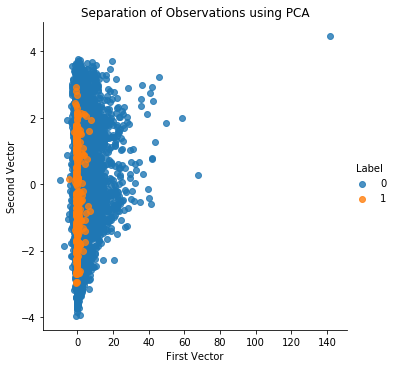

In [14]:
# 30 principal components as the number of features

"""
According to the lecture, 
"""
from sklearn.decomposition import PCA

n_components = 30

whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

Let's calculate the precision-recall curve and the ROC curve.


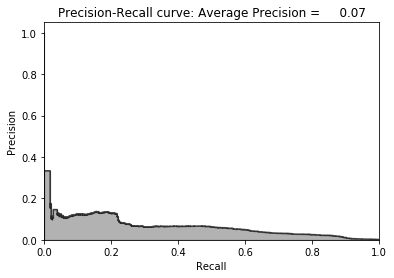

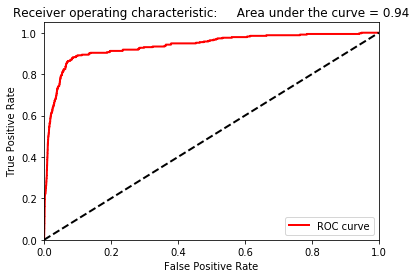

In [15]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

With an average precision of 0.08, this is a poor fraud detection solution. It catches very little of the fraud.

### Search for the Optimal Number of Principal Components

The idea right now is to reduce the number of PCA and evaluate the fraud detection results.

According to the book the best configuration is 27 components.

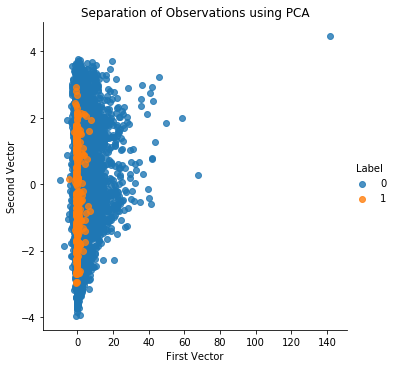

In [26]:
# 27 principal components
from sklearn.decomposition import PCA

n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

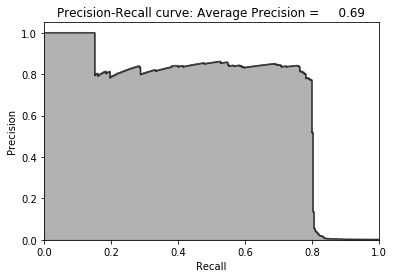

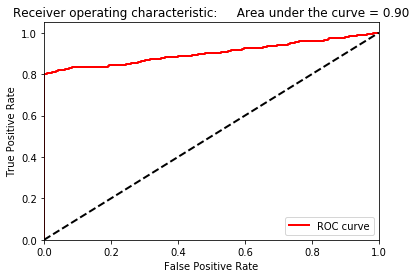

In [27]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

Wow, look how the precision increases! *Result using normal PCA and 27 principal components*

In [28]:
preds.sort_values(by="anomalyScore", ascending = False, inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ", np.round(predsTop.anomalyScore[predsTop.trueLabel == 1].count() / cutoff, 2))
print("Recall: ", np.round(predsTop.anomalyScore[predsTop.trueLabel == 1].count() / y_train.sum(), 2))

Precision:  0.75
Recall:  0.8


### Sparse PCA Anomaly Detection

Sparse PCA is similar to normal PCA but delivers a less dense version, we still need to specify the number of principal components we desire, but we must also set the aplha parameter, which controls the degree of sparsity. 

/home/kuky/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/sparse_pca.py:170: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


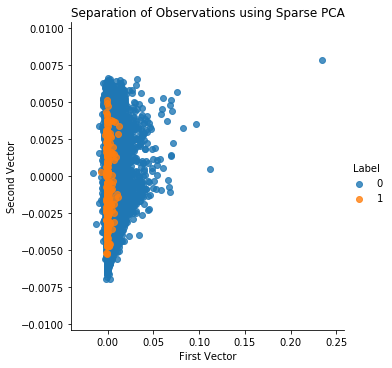

In [25]:
# Sparse PCA
from sklearn.decomposition import SparsePCA
n_components =  27
alpha = 0.0001
random_state = 2018
n_jobs = -1
sparsePCA = SparsePCA(n_components=n_components, alpha=alpha, random_state=random_state, n_jobs = n_jobs)
sparsePCA.fit(X_train)
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X_train.index)
scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

In [28]:
print("shape of the training set {}".format(X_train.shape))
print("shape of the sparse set {}".format(X_train_sparsePCA.shape))

shape of the training set (190820, 30)
shape of the sparse set (190820, 27)


Now let's generate the original dimensions from the sparse PCA matrix by simple matrix multiplication of the sparse PCA matrix. We also need to add the mean of each original feature to this new matrix. 

In [33]:
X_train_sparsePCA_inverse = np.array(X_train_sparsePCA).dot(sparsePCA.components_) + np.array(X_train.mean(axis=0))
X_train_sparsePCA_inverse = pd.DataFrame(data=X_train_sparsePCA_inverse, index=X_train.index)
X_train_sparsePCA_inverse.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
142087,-0.596636,-1.005945,1.156254,-0.137028,-0.241028,-0.358754,-0.090707,-0.217854,0.919084,-0.270209,...,0.233235,-0.222006,-0.683682,0.163298,-0.594361,-0.314125,0.213194,0.509139,0.451388,-0.356626
165168,0.646692,0.046099,0.685574,-0.137494,-0.350927,0.667460,-0.625366,0.795551,-0.126207,-0.167358,...,0.099470,-0.459884,-1.073228,0.139248,1.081781,-0.702981,0.230880,0.564507,0.263546,-0.306831
235908,1.572768,0.055506,-0.328768,-0.641341,-1.443025,-0.148061,-0.859313,1.172438,-0.547284,-2.742779,...,0.129379,0.581317,1.961918,0.520538,1.895371,-0.793212,0.219984,0.397749,0.820992,0.607285
148255,0.268998,-0.046231,0.550140,0.417943,-0.354334,0.238284,-0.751935,0.742747,-0.135727,-0.060411,...,-0.025414,-0.370806,-0.815106,0.105139,-0.020196,-0.830021,0.319331,0.620098,0.296733,-0.289130
145672,0.525746,-0.096097,0.554066,0.609053,-0.236586,0.617372,0.561391,0.170419,0.225278,-0.173143,...,0.144262,-0.245052,-0.601743,0.004232,-0.713169,-1.948158,-0.107843,0.591615,0.771743,-0.292685


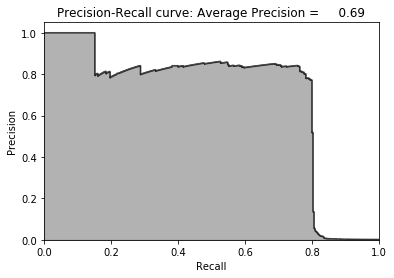

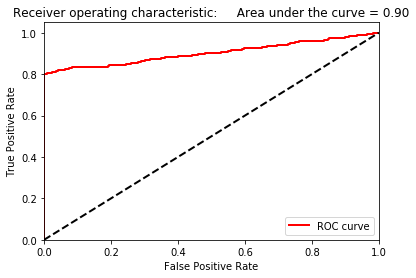

In [39]:
anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

In [29]:
preds.sort_values(by="anomalyScore", ascending = False, inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ", np.round(predsTop.anomalyScore[predsTop.trueLabel == 1].count() / cutoff, 2))
print("Recall: ", np.round(predsTop.anomalyScore[predsTop.trueLabel == 1].count() / y_train.sum(), 2))

Precision:  0.75
Recall:  0.8


### Kernel PCA Anomaly Detection

This approach is a nonlinear form of PCA and is useful if the fraud transactions are not linearly separable from nonfraud transactions. We need to specify the number of of components we would like to generate, the kernel (in this case we are going to use the RBF Kernel), and gamma (which is set 1/n_features by default, so 1/30).

*Kernel PCA is too expensive to train with*, so we can get a set of the data in order to experiment and translate the results to the other data.

In [31]:
# Kernel PCA
from sklearn.decomposition import KernelPCA
n_components = 27
kernel = "rbf"
gamma = None
fit_inverse_transform = True
random_state = 2018
n_jobs = 1
kernelPCA = KernelPCA(n_components=n_components,kernel=kernel, gamma=gamma, 
                      fit_inverse_transform=fit_inverse_transform, random_state=random_state,
                      n_jobs=n_jobs)
kernelPCA.fit(X_train.iloc[:2000])

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=True, gamma=None, kernel='rbf',
          kernel_params=None, max_iter=None, n_components=27, n_jobs=1,
          random_state=2018, remove_zero_eig=False, tol=0)

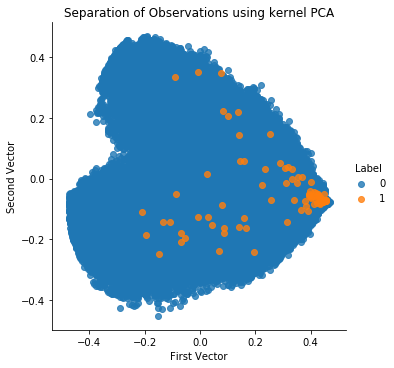

In [33]:
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data = X_train_kernelPCA, index= X_train.index)
X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, index = X_train.index)
scatterPlot(X_train_kernelPCA, y_train, "kernel PCA")

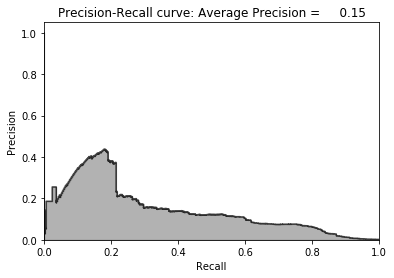

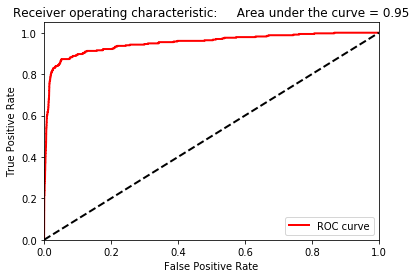

In [34]:
anomalyScoresSparsePCA = anomalyScores(X_train, X_train_kernelPCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)

## Gaussian Random Projection Anomaly Detection


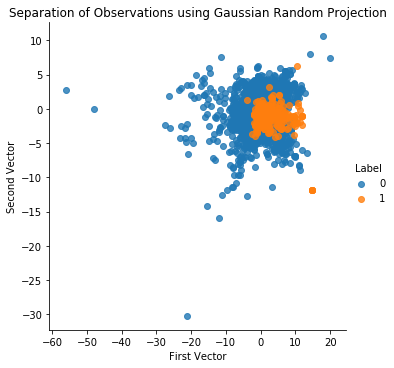

In [37]:
# Gaussian Random Projection

from sklearn.random_projection import GaussianRandomProjection
n_components = 27
eps = None
random_state = 2018
GRP = GaussianRandomProjection(n_components=n_components, eps=eps, random_state=random_state)
X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=X_train.index)
scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

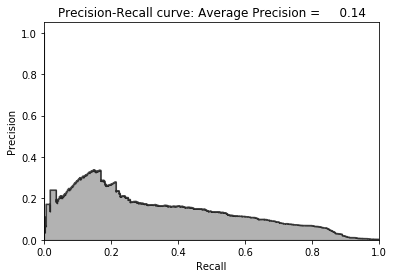

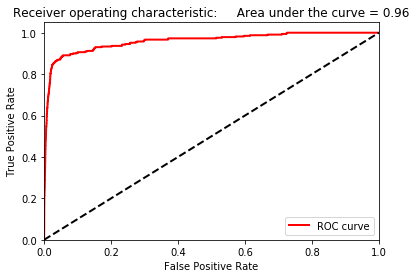

In [39]:
X_train_GRP_inverse = np.array(X_train_GRP).dot(GRP.components_)
X_train_GRP_inverse = pd.DataFrame(data=X_train_GRP_inverse, index=X_train.index)
anomalyScoresGRP = anomalyScores(X_train, X_train_GRP_inverse)
preds = plotResults(y_train, anomalyScoresGRP, True)

## Sparse Random Projection Anomaly Detection

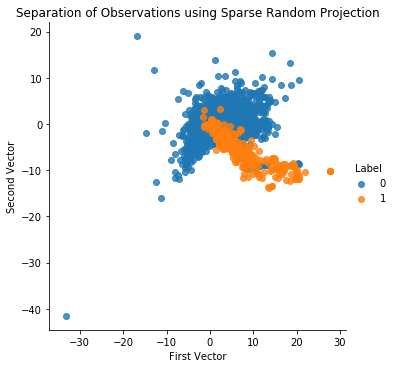

In [41]:
# Sparse Random Projection
from sklearn.random_projection import SparseRandomProjection
n_components = 27
density = "auto"
eps = .01
dense_output = True
random_state = 2018
SRP = SparseRandomProjection(n_components=n_components, density=density, eps=eps, dense_output=dense_output,
                            random_state=random_state)
X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=X_train.index)
scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

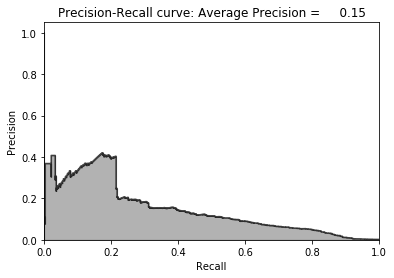

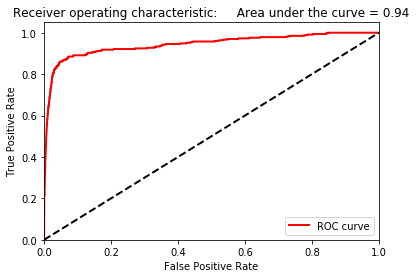

In [42]:
X_train_SRP_inverse = np.array(X_train_SRP).dot(SRP.components_.todense())
X_train_SRP_inverse = pd.DataFrame(data=X_train_SRP_inverse, index=X_train.index)

anomalyScoresSRP = anomalyScores(X_train, X_train_SRP_inverse)
plotResults(y_train, anomalyScoresSRP)

## Examples

The next example was taken from [1]

### Univariate Anomaly Detection

In [7]:
import pandas as pd

df = pd.read_excel("https://community.tableau.com/servlet/JiveServlet/downloadBody/1236-102-2-15278/Sample%20-%20Superstore.xls", encoding="latin1")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [12]:
df.columns = df.columns.str.replace(" ", "_").str.lower()

In [20]:
df.sales.describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: sales, dtype: float64

In [35]:
print("skewness {}".format(df.sales.skew()))
print("kurtosis {}".format(df.sales.kurt()))

skewness 12.972752341816228
kurtosis 305.31175324682283


the kurtosis allows us to understand that a lot of the data are concentrated to the median, on the other hand, the skewness shows that our distribution has a positive skewed (to the right)

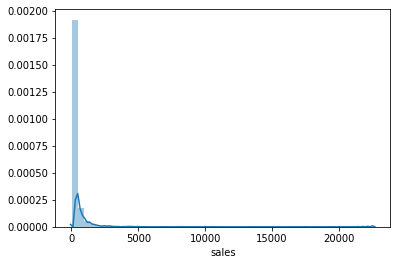

In [22]:
import seaborn as sns

sns.distplot(df.sales)

[Text(0, 0.5, 'Sales'),
 Text(0.5, 0, 'Index'),
 Text(0.5, 1.0, 'Sales distribution')]

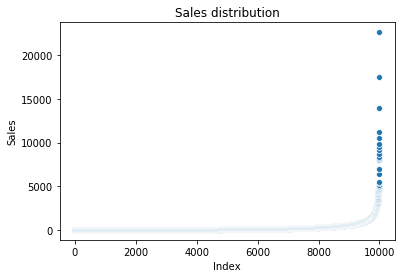

In [34]:
ax = sns.scatterplot(range(df.shape[0]), df.sales.sort_values(ascending=True).values)
ax.set(xlabel="Index", ylabel="Sales", title="Sales distribution")

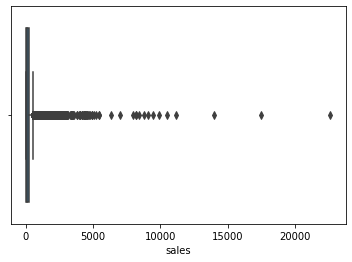

In [47]:
sns.boxplot(df.sales)

*Profit*

In [36]:
df.profit.describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: profit, dtype: float64

In [37]:
print("skewness {}".format(df.profit.skew()))
print("kurtosis {}".format(df.profit.kurt()))

skewness 7.561431562468336
kurtosis 397.188514552414


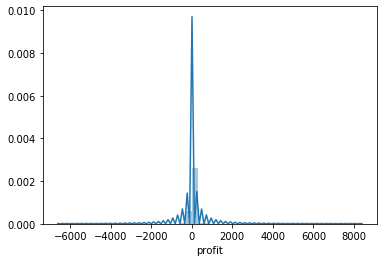

In [39]:
import seaborn as sns

sns.distplot(df.profit)

[Text(0, 0.5, 'Profit'),
 Text(0.5, 0, 'Index'),
 Text(0.5, 1.0, 'Profit distribution')]

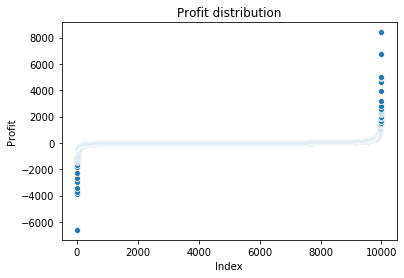

In [38]:
ax = sns.scatterplot(range(df.shape[0]), df.profit.sort_values(ascending=True).values)
ax.set(xlabel="Index", ylabel="Profit", title="Profit distribution")

We have another feature with positive tail and positive skewed and the data are heavy-tailed.

We have right now two regions where the data has low probability to appear: one on the right side of the distribution, another one on the left.

***
*Univariate Analysis*

**Isolation Forest** is an algorithm to detect outliers that returns the anomaly score of each sample using the IsolationForest algorithm which is based on the fact that anomalies are data points that are few and different. 

/home/kuky/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/kuky/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/kuky/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


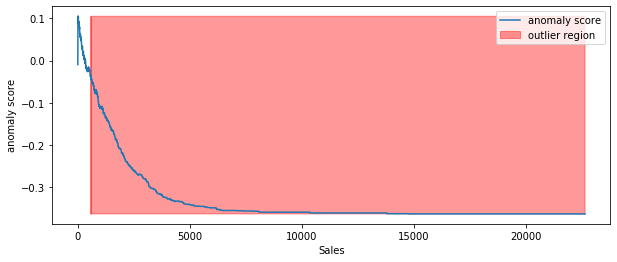

In [46]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df.sales.values.reshape(-1,1))

xx = pd.np.linspace(df.sales.min(), df.sales.max(), len(df)).reshape(-1, 1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], pd.np.min(anomaly_score), pd.np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show()

According to the last plot we can assume that the sales that exceeds 1000 would be definitely considered as an outlier.

/home/kuky/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/kuky/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/kuky/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


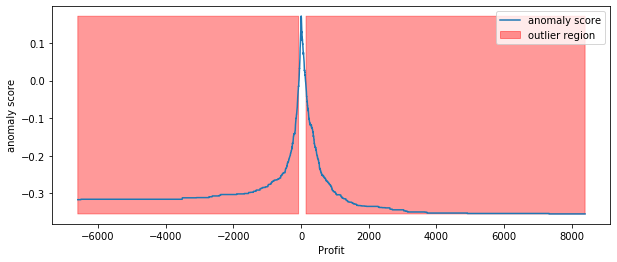

In [52]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df.profit.values.reshape(-1, 1))
xx = pd.np.linspace(df.profit.min(), df.profit.max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], pd.np.min(anomaly_score), pd.np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Profit')
plt.show();

Nothing to conclude

***
*Multivariate Anomaly Detection*

Let's apply an unsupervised multivariate anomaly detection method, one of them is PyOD proposed by Yue Zhao.

**Sales & Profit**

We expect that SAlaes and & Profit are positive correlated. If some of the Slaes data points and Profit data points are not positive correlated, they would be considered as outliers and need to be further studied.

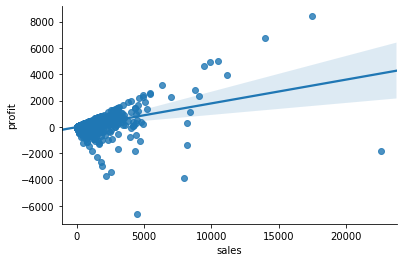

In [57]:
sns.regplot(x="sales", y="profit", data=df)
sns.despine()

From the last plot we can see that some of the points are obvious outliers such as extreme low and extreme high values.

### *Cluster-based Local Outlier Factor (CBLOF)*

Let's the application of *Cluster-based Local Outlier Factor (CBLOF)* that calculates the outlier score. An anomaly score is computed by the distance of each instance to its cluster center multiplied by the instances belonging to its cluster. PyOD library includes the CBOLF implementation.

In [70]:
"""
Scaling Sales and Profit to between zero and one 
We're going to set outliers fraction as 1% based on trial and best guess
Use the threshold value to consider a data point is inlier or outlier
""" 
from pyod.models.cblof import CBLOF
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler(feature_range=(0, 1))
df[['sales', 'profit']] = minmax.fit_transform(df[['sales', 'profit']])
X1 = df['sales'].values.reshape(-1, 1)
X2 = df['profit'].values.reshape(-1, 1)
X = pd.np.concatenate((X1, X2), axis=1)


outliers_fraction = 0.01
# Return coordinate matrices from coordinate vectors.
xx, yy = pd.np.meshgrid(pd.np.linspace(0, 1, 100), pd.np.linspace(0, 1, 100))
clf  =  CBLOF(contamination = outliers_fraction, check_estimator=False, random_state=0)
clf.fit(X)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.01, n_clusters=8, n_jobs=1, random_state=0,
   use_weights=False)

In [73]:
y_pred = clf.predict(X)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [74]:
scores_pred = clf.decision_function(X) * -1

In [75]:
n_inliers = len(y_pred) - pd.np.count_nonzero(y_pred)
n_outliers = pd.np.count_nonzero(y_pred == 1)

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [109]:
# sales - inlier feature 1, profit - inlier feature 2
df1 = pd.DataFrame(y_pred.tolist(), columns=["outlier"])
inliers_sales = pd.np.array(df['sales'][df1['outlier'] == 0]).reshape(-1, 1)
inliers_profit = pd.np.array(df['profit'][df1['outlier'] == 0]).reshape(-1, 1)

In [111]:
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = pd.np.array(df['sales'][df1['outlier'] == 1]).reshape(-1, 1)
outliers_profit = pd.np.array(df['profit'][df1['outlier'] == 1]).reshape(-1, 1)

In [112]:
threshold = pd.np.percentile(scores_pred, 100 * outliers_fraction)

In [114]:
Z = clf.decision_function(pd.np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

Outliers: 100 inliers: 9894


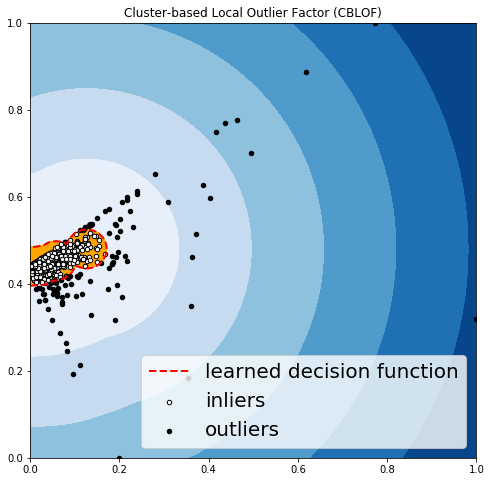

In [124]:
import matplotlib.pyplot as plt
import matplotlib 

print("Outliers:",n_outliers, "inliers:",n_inliers)
plt.figure(figsize=(8,8))

plt.contourf(xx, yy, Z, levels=pd.np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)

a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors="red")
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c="white", s=20, edgecolor="k")
c = plt.scatter(outliers_sales, outliers_profit, c="black", s=20, edgecolor="k")

plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();

### *Histogram-based Outlier Detection (HBOS)*

HBOS assumes the feature indepence and calculates the degree of anomalies by building histograms. In mutivariate anomaly detection, a histogram for each single feature can be computed, scored individually and combined at the end. 

## References

+ [1] https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1